In [1]:
!python --version
!date
!which python

Python 3.12.4
Sun Sep 29 14:36:18 CST 2024
/public/workspace/ryrl/venvs/versions/3.12.4/torch/bin/python


In [39]:
import os
import sys
import torch
import numpy as np
import scanpy as sc
import pandas as pd
import seaborn as sns
import networkx as nx
import torch.nn as nn

import matplotlib.pylab as plt

import torch.nn.functional as F
from torch_geometric.nn import GATConv, GATv2Conv, SuperGATConv


from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from torch_geometric.data import Data
from sklearn.preprocessing import normalize
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity

sns.set_style(style='white')
# sns.set_theme(style=)

%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 1.28 ms (started: 2024-09-30 17:44:53 +08:00)


In [40]:
adata = sc.read_h5ad('/public/workspace/ryrl/projects/classmates/ryrl/GraphCausal/10X/GEMXHumanPBMC.h5ad')
adata

AnnData object with n_obs × n_vars = 10237 × 38606
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'doublet_score', 'predicted_doublet'
    var: 'gene_ids', 'feature_types', 'genome', 'pattern', 'read', 'sequence', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p', 'scrublet'
    layers: 'counts'

time: 655 ms (started: 2024-09-30 17:44:56 +08:00)


In [3]:
# df = adata.to_df()
# coef = np.corrcoef(df, rowvar=True)
# coef.shape
# def normalization_for_NE(features_):
#     features = features_.copy()
#     for i in range(len(features)):
#         features[i] = features[i] / sum(features[i]) * 1000000
#     features = np.log2(features + 1)
#     return features
# @njit
# def NE_dn(w, N, eps):
#     w = w * N
#     D = np.sum(np.abs(w), axis=1) + eps
#     # D = 1 / D
#     # D = np.diag(D)
#     wn = np.dot(np.diag(1 / D), w)
#     return wn
# 
# # @njit
# def dominateset(aff_matrix, NR_OF_KNN):
#     thres = np.sort(aff_matrix)[:, -NR_OF_KNN]
#     
#     mask = aff_matrix >= thres[:, np.newaxis]
#     
#     # aff_matrix.T[aff_matrix.T < thres] = 0
#     aff_matrix = aff_matrix * mask
#     aff_matrix = (aff_matrix + aff_matrix.T) / 2
#     return aff_matrix
# 
# def TransitionFields(W, N, eps):
#     W = W * N
#     W = NE_dn(W, N, eps)
#     w = np.sqrt(np.sum(np.abs(W), axis=0) + eps)
#     W = W / np.expand_dims(w, 0).repeat(N, 0)
#     W = np.dot(W, W.T)
#     return W
# 
# def getNeMatrix(W_in):
#     N = len(W_in)
# 
#     K = min(20, N // 10)
#     alpha = 0.9
#     order = 3
#     eps = 1e-20
# 
#     W0 = W_in * (1 - np.eye(N))
#     W = NE_dn(W0, N, eps)
#     W = (W + W.T) / 2
# 
#     DD = np.sum(np.abs(W0), axis=0)
# 
#     P = (dominateset(np.abs(W), min(K, N - 1))) * np.sign(W)
#     P = P + np.eye(N) + np.diag(np.sum(np.abs(P.T), axis=0))
# 
#     P = TransitionFields(P, N, eps)
# 
#     D, U = np.linalg.eig(P)
#     d = D - eps
#     d = (1 - alpha) * d / (1 - alpha * d ** order)
#     D = np.diag(d)
#     W = np.dot(np.dot(U, D), U.T)
#     W = (W * (1 - np.eye(N))) / (1 - np.diag(W))
#     W = W.T
# 
#     D = np.diag(DD)
#     W = np.dot(D, W)
#     W[W < 0] = 0
#     W = (W + W.T) / 2
#     return W
# 
# 
# def getGraph(co_matrix, NE_matrix, L, K):
#     
#     sim_sh = 1.
#     for i in range(len(NE_matrix)):
#         NE_matrix[i][i] = sim_sh * max(NE_matrix[i])
#     
#     data = NE_matrix.reshape(-1)
#     data = np.sort(data)
#     data = data[:-int(len(data)*0.02)]
#     
#     min_sh = data[0]
#     max_sh = data[-1]
#     
#     delta = (max_sh - min_sh) / 100
# 
#     temp_cnt = []
#     for i in range(20):
#         s_sh = min_sh + delta * i
#         e_sh = s_sh + delta
#         temp_data = data[data > s_sh]
#         temp_data = temp_data[temp_data < e_sh]
#         temp_cnt.append([(s_sh + e_sh)/2, len(temp_data)])
#     
#     candi_sh = -1
#     for i in range(len(temp_cnt)):
#         pear_sh, pear_cnt = temp_cnt[i]
#         if 0 < i < len(temp_cnt) - 1:
#             if pear_cnt < temp_cnt[i+1][1] and pear_cnt < temp_cnt[i-1][1]:
#                 candi_sh = pear_sh
#                 break
#     if candi_sh < 0:
#         for i in range(1, len(temp_cnt)):
#             pear_sh, pear_cnt = temp_cnt[i]
#             if pear_cnt * 2 < temp_cnt[i-1][1]:
#                 candi_sh = pear_sh
#     if candi_sh == -1:
#         candi_sh = 0.3
#     
#     propor = len(NE_matrix[NE_matrix <= candi_sh])/(len(NE_matrix)**2)
#     propor = 1 - propor
#     thres = np.sort(NE_matrix)[:, -int(len(NE_matrix)*propor)]
#     co_matrix.T[NE_matrix.T <= thres] = 0
#             
#     # else:
#     #     return
# 
#     N = len(co_matrix)
#     
#     up_K = np.sort(co_matrix)[:,-K]
#     
#     mat_K = np.zeros(co_matrix.shape)
#     mat_K.T[co_matrix.T >= up_K] = 1
#     
#     thres_L = np.sort(co_matrix.flatten())[-int(((N*N)//(1 // (L+1e-8))))]
#     mat_K.T[co_matrix.T < thres_L] = 0
# 
#     return mat_K
# coef_ = getNeMatrix(coef)
# similarty_matrix = pd.read_csv('/public/workspace/ryrl/projects/classmates/ryrl/GraphCausal/10X/GEMXHumanPBMC_NE_Matrix.parquet', index_col=0)
# coef_ = similarty_matrix.values
# similarty_matrix.head()
# pd.DataFrame(coef_, columns=df.index, index=df.index).to_csv('/public/workspace/ryrl/projects/classmates/ryrl/GraphCausal/10X/GEMXHumanPBMC_NE_Matrix.parquet')
# similarty_matrix = pd.DataFrame(coef_, columns=df.index, index=df.index)
# similarty_matrix.head()
# N = len(similarty_matrix)
# avg_N = N // 20
# K = avg_N // 10
# K = min(K, 20)
# K = max(K, 6)

# graph = getGraph(co_matrix=coef, NE_matrix=coef_, L=0, K=6)


# G = nx.from_pandas_adjacency(demo_)
# nx.number_connected_components(G)
# import matplotlib.pylab as plt
# pos = nx.spring_layout(G)
# nx.draw(G, pos, node_size=50, with_labels=False)
# plt.show()

(10237, 10237)

time: 11 s (started: 2024-09-30 11:00:23 +08:00)


In [3]:
similarty = cosine_similarity(adata.to_df())

time: 7.45 s (started: 2024-09-30 13:23:56 +08:00)


In [4]:
K = 10
indices = np.argsort(-similarty, axis=1)[:, 1:K+1]
adjacency_matrix = np.zeros_like(similarty)
adjacency_matrix[np.arange(similarty.shape[0])[:, np.newaxis], indices] = 1

time: 3.05 s (started: 2024-09-30 13:24:17 +08:00)


In [14]:
edge_index = np.array(np.nonzero(adjacency_matrix))
edge_index = torch.tensor(edge_index, dtype=torch.long)
edge_weight = similarty[edge_index[0], edge_index[1]]

time: 883 ms (started: 2024-09-30 14:24:29 +08:00)


In [15]:
X = torch.tensor(adata.to_df().values)
edge_weight = torch.tensor(edge_weight, dtype=torch.float)
data = Data(x=X, edge_index=edge_index, edge_weight=edge_weight)

time: 1.32 s (started: 2024-09-30 14:25:13 +08:00)


In [17]:
# torch.save(obj=data, f='/public/workspace/ryrl/projects/classmates/ryrl/GraphCausal/10X/Graph.pt')

time: 4 s (started: 2024-09-30 14:43:39 +08:00)


In [41]:
adata

AnnData object with n_obs × n_vars = 10237 × 38606
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'doublet_score', 'predicted_doublet'
    var: 'gene_ids', 'feature_types', 'genome', 'pattern', 'read', 'sequence', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p', 'scrublet'
    layers: 'counts'

time: 2.02 ms (started: 2024-09-30 17:45:13 +08:00)


In [43]:
sc.tl.pca(adata)
X_ = normalize(adata.obsm['X_pca'], norm='l2', axis=1)
X_

time: 6.01 s (started: 2024-09-30 17:47:26 +08:00)


In [52]:
similarty = cosine_similarity(X_)
similarty.shape

(10237, 10237)

time: 670 ms (started: 2024-09-30 17:50:31 +08:00)


In [53]:
K = 10
indices = np.argsort(-similarty, axis=1)[:, 1:K + 1]
adjacency_matrix = np.zeros_like(similarty)
adjacency_matrix[np.arange(similarty.shape[0])[:, np.newaxis], indices] = 1
edge_index = np.array(np.nonzero(adjacency_matrix))
edge_index = torch.tensor(edge_index, dtype=torch.long)
edge_weight = similarty[edge_index[0], edge_index[1]]
X = torch.tensor(adata.to_df().values)
edge_weight = torch.tensor(edge_weight, dtype=torch.float)
data = Data(x=X_, edge_index=edge_index, edge_weight=edge_weight)

time: 4.82 s (started: 2024-09-30 17:50:42 +08:00)


# <font color='#FFDC91FF'>Graph Cluster</font>

In [2]:
data = torch.load('/public/workspace/ryrl/projects/classmates/ryrl/GraphCausal/10X/Graph.pt')
data

Data(x=[10237, 38606], edge_index=[2, 102370], edge_weight=[102370])

time: 2.05 s (started: 2024-09-30 15:09:55 +08:00)


In [55]:
class GATAutoEncoder(nn.Module):
    
    def __init__(self, in_channel: int = 38606, hidden_channel: int = 512, embedding_dim: int = 128, num_heads: int = 8):
        super().__init__()
        self.encoder = GATConv(in_channels=in_channel, out_channels=hidden_channel, heads=num_heads, concat=True)
        self.embedding = nn.Linear(in_features=hidden_channel * num_heads, out_features=embedding_dim)
        self.decoder = nn.Linear(in_features=embedding_dim, out_features=in_channel)
    
    def forward(self, x, edge_index, edge_weight):
        x = self.encoder(x, edge_index, edge_weight)
        x = F.relu(x)
        z = self.embedding(x)
        x = self.decoder(z)
        return x, z

time: 1.05 ms (started: 2024-09-30 17:50:54 +08:00)


time: 1.41 s (started: 2024-09-30 17:50:54 +08:00)


In [56]:
model = GATAutoEncoder()
optimizer = torch.optim.Adam(params=model.parameters(), lr=.001, weight_decay=5e-4)
loss_fn = torch.nn.MSELoss()

time: 2.39 s (started: 2024-09-30 17:50:57 +08:00)


In [58]:
num_epochs = 200
lst = []
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    
    x, z = model(x=data.x, edge_index=data.edge_index, edge_weight=data.edge_weight)
    loss = loss_fn(x, data.x)
    loss.backward()
    optimizer.step()
    
    lst.append((epoch, loss))
    if epoch % 10 == 0:
        print(f'Epoch: {epoch + 1}, Loss: {loss.item(): .4f}')

ValueError: too many values to unpack (expected 2)

time: 91.2 ms (started: 2024-09-30 17:51:23 +08:00)


In [14]:
df = pd.DataFrame(lst, columns=['Epoch', 'Loss'])
df = df.assign(Loss=df['Loss'].apply(lambda x: x.item()))
df.head()

,Epoch,Loss
0,0,0.188651
1,1,27.232084
2,2,0.554633
3,3,0.227159
4,4,0.327618


time: 7.34 ms (started: 2024-09-30 16:28:21 +08:00)


<Axes: xlabel='Epoch', ylabel='Loss'>

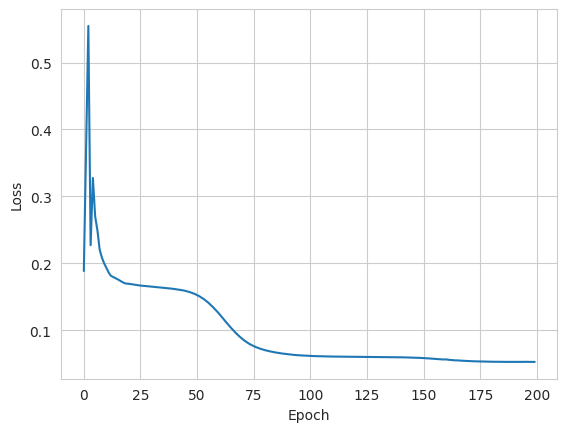

time: 198 ms (started: 2024-09-30 16:30:00 +08:00)


In [16]:
sns.lineplot(data=df.drop(index=1), x='Epoch', y='Loss')

In [18]:
model.eval()
with torch.no_grad():
    _, embeddings = model(data.x, data.edge_index, edge_weight=data.edge_weight)
    embeddings = embeddings.cpu().numpy()

time: 2.9 s (started: 2024-09-30 16:30:36 +08:00)


In [ ]:
# 聚类
num_clusters = 13  # 根据您的数据情况调整
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
labels = kmeans.fit_predict(embeddings)

Text(0, 0.5, 'Dimension 2')

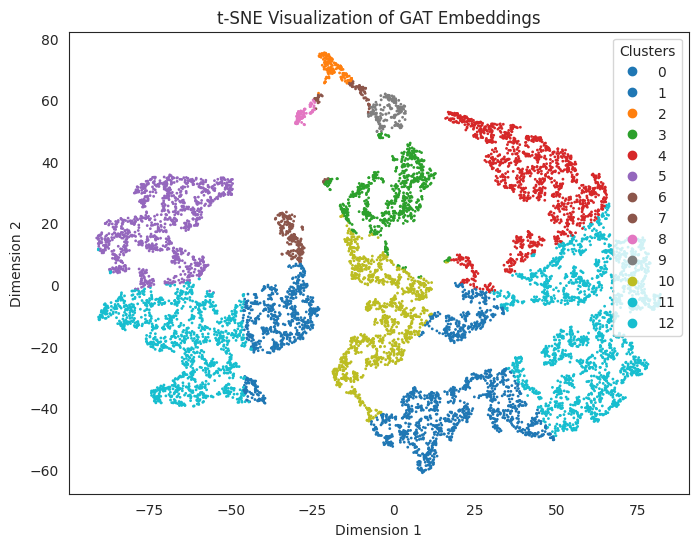

time: 1min 40s (started: 2024-09-30 17:37:15 +08:00)


In [36]:
# 可视化
tsne = TSNE(n_components=2, random_state=0, perplexity=50)
embeddings_2d = tsne.fit_transform(embeddings)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels, cmap='tab10', s=1)
plt.legend(*scatter.legend_elements(), title='Clusters')
plt.title('t-SNE Visualization of GAT Embeddings')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')

In [27]:
embeddings.shape

(10237, 128)

time: 1.88 ms (started: 2024-09-30 16:39:22 +08:00)


In [33]:
pd.concat([pd.DataFrame(embeddings), pd.DataFrame(labels)], axis=1)

,0,1,2,3,4,5,6,7,8,9,...,119,120,121,122,123,124,125,126,127,0
0,-0.717167,-0.773687,0.873569,-1.217307,-0.833975,-1.151510,-0.574893,0.938007,1.002415,-1.123530,...,-0.752877,0.971335,0.950924,-0.874536,0.932053,-0.725580,0.916555,0.665468,-0.982224,12
1,-0.673679,-0.782912,0.904707,-1.260333,-0.766979,-1.135578,-0.575872,0.976531,0.975664,-1.146360,...,-0.725338,0.942590,0.943171,-0.850863,0.951672,-0.706804,0.939280,0.676932,-0.975388,10
2,-0.701803,-0.759898,0.877931,-1.225918,-0.804961,-1.137211,-0.575240,0.938557,0.976148,-1.118070,...,-0.739224,0.959983,0.930031,-0.851915,0.935552,-0.723049,0.913114,0.648690,-0.971139,1
3,-0.693621,-0.746016,0.850604,-1.181778,-0.809330,-1.118912,-0.554628,0.911104,0.974014,-1.095646,...,-0.739361,0.941796,0.920048,-0.846401,0.902896,-0.716720,0.884456,0.628313,-0.954349,4
4,-0.690096,-0.750854,0.872267,-1.208145,-0.796809,-1.122244,-0.565425,0.929411,0.975296,-1.103235,...,-0.725007,0.949490,0.929682,-0.843346,0.919479,-0.723805,0.900050,0.647875,-0.960995,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10232,-0.606762,-0.880077,0.867318,-1.213473,-0.695698,-1.078422,-0.540987,1.014905,1.006307,-1.221224,...,-0.880220,0.926716,0.903165,-0.861256,1.079077,-0.684402,1.092310,0.754142,-0.953922,5
10233,-0.696089,-0.786565,0.911492,-1.276706,-0.796615,-1.165972,-0.593013,0.985281,0.997113,-1.150508,...,-0.738715,0.967728,0.956301,-0.872542,0.964657,-0.727320,0.947934,0.676292,-0.986255,10
10234,-0.665710,-0.728607,0.819958,-1.134489,-0.780895,-1.076002,-0.549710,0.874139,0.943337,-1.057096,...,-0.716732,0.902456,0.883600,-0.821325,0.861695,-0.693474,0.860141,0.601200,-0.927701,4
10235,-0.690483,-0.749501,0.839353,-1.176223,-0.803347,-1.112752,-0.556712,0.902118,0.969129,-1.087572,...,-0.726582,0.939950,0.913631,-0.838670,0.897854,-0.705060,0.884534,0.635338,-0.953407,4


time: 22.3 ms (started: 2024-09-30 16:41:24 +08:00)
